# Importing modules

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

# Input data and modification

In [2]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

In [3]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

In [4]:
nltk.download('punkt')
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))

In [7]:
nltk.download('wordnet')
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Best parameters for vectorization

In [8]:
tfidf = TfidfVectorizer(use_idf=True)
y = spam_dataset['Spam']
clf = RandomForestClassifier(max_depth=2, random_state=0)
pipeline = Pipeline([
           ('vect', tfidf),
          
           ('clf', clf)
])
parameters = [{
    'vect__max_df': (0.2, 0.5),
    'vect__min_df': (0.0005 , 0.001),
    'vect__ngram_range': ((1, 1), (2, 2)),
    'clf__max_depth': [2,3, 5, 10]
}]
grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)),y)

GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(max_depth=2,
                                                               random_state=0))]),
             param_grid=[{'clf__max_depth': [2, 3, 5, 10],
                          'vect__max_df': (0.2, 0.5),
                          'vect__min_df': (0.0005, 0.001),
                          'vect__ngram_range': ((1, 1), (2, 2))}])

In [9]:
grid_search.best_params_

{'clf__max_depth': 10,
 'vect__max_df': 0.2,
 'vect__min_df': 0.001,
 'vect__ngram_range': (1, 1)}

# Vectorization and train test split

In [10]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), max_df=0.2, min_df=0.001, use_idf=True)
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

# Feature importances bigger than 0.001

In [11]:
clf.fit(X_train,y_train)
importances = clf.feature_importances_

In [12]:
features=np.where(importances>0.001)
X_train=X_train[features]
y_train=y[features[0]]

# Best parameters for random forest

In [13]:
pipeline_2 = Pipeline([

           ('clf', RandomForestClassifier( random_state=0))
])
parameters = [{
    'clf__max_depth': [1,2,10],
}]
grid_search = GridSearchCV(pipeline_2, parameters,scoring="roc_auc")

grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=0))]),
             param_grid=[{'clf__max_depth': [1, 2, 10]}], scoring='roc_auc')

In [14]:
grid_search.best_params_

{'clf__max_depth': 2}

# F1 score, AUC score, confusion matrix and model test score

In [15]:
model_best = grid_search.best_estimator_

def metric(model,X_test):
    predictions_test = model.predict(X_test)
    f1_score_test=f1_score(y_test, predictions_test)
    print(f"F1_score_test: {f1_score_test}")
    
metric(model_best, X_test)

F1_score_test: 0.0


In [16]:
predictions_proba = model_best.predict_proba(X_test)
auc_metric = roc_auc_score(y_test, predictions_proba[:,1])

In [17]:
auc_metric

0.6365174316005946

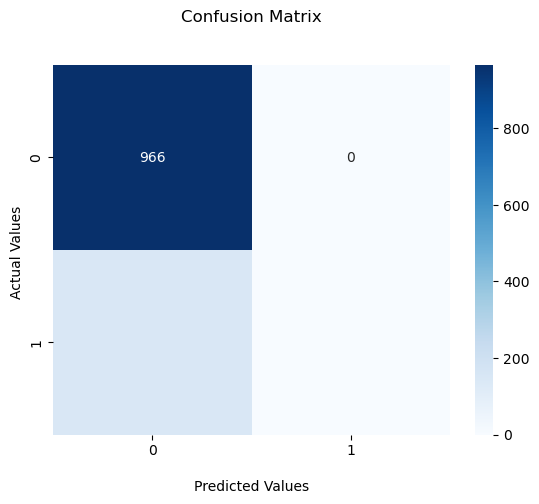

In [18]:
plt.figure()
cm = confusion_matrix(y_test, model_best.predict(X_test))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [19]:
model_best.score(X_test,y_test)

0.8663677130044843

### Because the data set is heavily skewed, the model always predicts the same outcome as seen in the confusion matrix. This means that the F1 score will be 0 by default. Therefore, the AUC score is more relevant, which is decent in this case. However, the model test score is pretty satisfying.